<a href="https://colab.research.google.com/github/buriro-ezekia/Inclusive-Activity-Based-Learning-ABL-Assessment-in-Mathematics/blob/main/Husini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import glob
import os

# --- STEP 1: Google Drive Mounting (Needed in Colab/Notebook Environments) ---
# NOTE: If you are running this code outside of Google Colab, you should comment
# out the 'from google.colab import drive' block and replace the 'base_path'
# with your local file path (e.g., base_path = 'C:/Users/...')
try:
    # Attempt to use the google.colab specific import for mounting
    from google.colab import drive
    print("Attempting to mount Google Drive...")
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/Husuni'
    print(f"Drive mounted. Searching for files in: {base_path}")
except ImportError:
    # Fallback for local environments
    print("Google Colab environment not detected. Assuming local execution.")
    # **UPDATE THIS PATH if running locally**
    base_path = 'drive/MyDrive/Husuni'

# --- STEP 2: Find CSV Files ---
# Use glob to find all files ending with .csv in the specified directory
csv_files = glob.glob(os.path.join(base_path, '*.csv'))

if not csv_files:
    print(f"\nERROR: No CSV files found in the directory: {base_path}")
    print("Please ensure the path is correct and the CSV files exist.")
else:
    print(f"\nSUCCESS: Found {len(csv_files)} CSV file(s). Running inspection on each file...")

    # --- STEP 3 & 4: Load and Inspect ALL DataFrames ---
    for i, file_path in enumerate(csv_files):
        print(f"\n=======================================================")
        print(f"  INSPECTING FILE {i + 1} OF {len(csv_files)}: {os.path.basename(file_path)}")
        print(f"=======================================================")

        # We start by attempting header=1 because the original file had an offset header.
        # If this fails, we fall back to header=0.
        try:
            df = pd.read_csv(file_path, header=1)
            header_used = 1
        except Exception as e:
            print(f"Warning: Reading with header=1 failed ({e}). Falling back to header=0.")
            try:
                df = pd.read_csv(file_path, header=0)
                header_used = 0
            except Exception as e:
                print(f"ERROR: Could not read file {os.path.basename(file_path)} with header=0 or header=1: {e}")
                continue # Skip to the next file

        print(f"DataFrame loaded successfully using header={header_used}.")

        # Display the first 5 rows of the DataFrame
        print("\n--- df.head() ---")
        print(df.head())

        # Check data types, non-null counts, and memory usage
        print("\n--- df.info() ---")
        df.info()

        # Get descriptive statistics for numerical columns
        print("\n--- df.describe() ---")
        # Ensure we only try to describe if the DF isn't empty after loading
        if not df.empty:
            print(df.describe(include='all')) # include='all' shows stats for categorical data too
        else:
            print("DataFrame is empty.")

        # List all column names to identify variables for Objectives
        print("\n--- df.columns ---")
        print(df.columns.tolist())

    print("\n--- Inspection Complete ---")
    print("Please analyze the output for all five files to identify the columns for:")
    print("1. Teacher Knowledge & Challenges (Likert scale responses)")
    print("2. Student Performance (Pre/Post Test Scores)")


Attempting to mount Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted. Searching for files in: /content/drive/MyDrive/Husuni

SUCCESS: Found 6 CSV file(s). Running inspection on each file...

  INSPECTING FILE 1 OF 6: Teachers knowledge in activity based methods.csv
DataFrame loaded successfully using header=1.

--- df.head() ---
   1   Stongly Agree  Strongly Agree Strongly Agree.1 Strongly Agree.2  \
0  2  Strongly Agree           Agree            Agree   Strongly Agree   
1  3           Agree           Agree            Agree            Agree   
2  4  Strongly Agree  Strongly Agree            Agree            Agree   
3  5           Agree           Agree   Strongly Agree            Agree   
4  6  Strongly Agree           Agree   Strongly Agree   Strongly Agree   

  Strongly Agree.3 Strongly Agree.4 Strongly Agree.5 Strongly Agree.6  \
0   Strongly Agree   Strongly Agree      

In [ ]:
# --- Exclusion Step BEFORE Analysis ---
# Create a filtered dataframe for analysis that requires complete teacher data
df_master_clean = df_master.dropna(subset=['Gender_Teacher', 'Knowledge_Score', 'Challenge_Score']).copy()

# A. Correlation: Teacher Variables vs. Student Performance Gain (Use df_master_clean)
df_corr = df_master_clean.dropna(subset=['Performance_Gain'])
# Re-run correlation on the clean data...

# B. ANCOVA for Inclusive Enhancement (Student Gender) (Use original df_master, Teacher data not needed here)
df_ancova_gender = df_master.dropna(subset=['Post_Test_Score', 'Pre_Test_Score', 'Gender_Student'])
# Re-run ANCOVA B...

# C. ANCOVA: Post-Test Score by Teacher Training (Use df_master_clean for 'Trained')
df_ancova_trained = df_master_clean.dropna(subset=['Post_Test_Score', 'Pre_Test_Score', 'Trained'])
# Re-run ANCOVA C...

# --- Output Handling ---
print("Master DataFrame Head (Teacher Data Only, Missing Teacher 1 Filtered):")
# Filter the output display to exclude Teacher ID 1
print(df_master[df_master['Teacher_ID'] != 1][['Teacher_ID', 'Gender_Teacher', 'Experience', 'Qualification', 'Trained', 'Knowledge_Score', 'Challenge_Score']].head().to_string())

Master DataFrame Head (Teacher Data Only, Missing Teacher 1 Filtered):
   Teacher_ID Gender_Teacher  Experience    Qualification  Trained  Knowledge_Score  Challenge_Score
1           2           Male        10.0             PGDE      0.0         4.266667           4.0000
2           3         Female         2.0  Bachelor Degree      0.0         3.933333           3.0625
3           4           Male        15.0  Bachelor Degree      0.0         4.200000           3.4375
4           5           Male         1.0  Bachelor Degree      1.0         4.133333           1.5000
5           6           Male         3.0  Bachelor Degree      0.0         4.666667           3.5000


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Opt-in to the future pandas behavior to resolve the FutureWarning
pd.set_option('future.no_silent_downcasting', True)

# --- Configuration: Define correct file names from inspection ---
files = {
    'knowledge': 'drive/MyDrive/Husuni/Teachers knowledge in activity based methods.csv',
    'challenges': 'drive/MyDrive/Husuni/Challenges teacher face in activity based methods.csv',
    'demographics': 'drive/MyDrive/Husuni/Teachers Demographics.csv',
    'impact': 'drive/MyDrive/Husuni/Impact of activity-Based Learning on student performance II.csv'
}

# Define general Likert scale mapping (5-point) for scoring
likert_mapping = {'Strongly Agree': 5, 'Agree': 4, 'Neutral': 3, 'Disagree': 2, 'Strongly Disagree': 1,
                  'Stongly Agree': 5, 'Strongly  Agree': 5, 'Strongly Adisagree': 1}

# --- 1. Load Teacher Demographics (File 5) ---
df_demographics = pd.read_csv(files['demographics'], header=1)
# Assign column names based on inspection assumption
df_demographics.columns = ['Teacher_ID', 'Gender', 'Age', 'Experience', 'Qualification', 'Training_Received', 'Agreement_on_ABL']
df_demographics['Teacher_ID'] = pd.to_numeric(df_demographics['Teacher_ID'], errors='coerce').astype('Int64')

# Rename Gender column in demographics BEFORE merging to avoid KeyError
df_demographics.rename(columns={'Gender': 'Gender_Teacher'}, inplace=True)

# Standardize 'Training_Received' and create 'Trained' factor
df_demographics['Training_Received'] = df_demographics['Training_Received'].astype(str).str.strip().str.replace('es', 'Yes', case=False)
df_demographics['Training_Received'] = df_demographics['Training_Received'].str.replace('no', 'No', case=False)
df_demographics['Trained'] = np.where(df_demographics['Training_Received'] == 'Yes', 1, 0)


# --- 2. Load Teacher Knowledge (File 1) and Calculate Score ---
df_knowledge = pd.read_csv(files['knowledge'], header=1)
df_knowledge.rename(columns={'1': 'Teacher_ID'}, inplace=True)
df_knowledge['Teacher_ID'] = pd.to_numeric(df_knowledge['Teacher_ID'], errors='coerce').astype('Int64')

knowledge_cols = df_knowledge.columns.drop('Teacher_ID')
for col in knowledge_cols:
    # Applying the replacement without explicit downcasting to avoid FutureWarning
    df_knowledge[col] = df_knowledge[col].astype(str).str.strip().replace(likert_mapping, regex=False)

df_knowledge[knowledge_cols] = df_knowledge[knowledge_cols].apply(pd.to_numeric, errors='coerce')
df_knowledge['Knowledge_Score'] = df_knowledge[knowledge_cols].mean(axis=1)
df_knowledge = df_knowledge[['Teacher_ID', 'Knowledge_Score']]


# --- 3. Load Teacher Challenges (File 2) and Calculate Score ---
df_challenges = pd.read_csv(files['challenges'], header=1)
df_challenges.rename(columns={'1': 'Teacher_ID'}, inplace=True)
df_challenges['Teacher_ID'] = pd.to_numeric(df_challenges['Teacher_ID'], errors='coerce').astype('Int64')

challenge_likert_cols = df_challenges.columns.drop('Teacher_ID')
for col in challenge_likert_cols:
    # Applying the replacement without explicit downcasting to avoid FutureWarning
    df_challenges[col] = df_challenges[col].astype(str).str.strip().replace(likert_mapping, regex=False)

df_challenges[challenge_likert_cols] = df_challenges[challenge_likert_cols].apply(pd.to_numeric, errors='coerce')
df_challenges['Challenge_Score'] = df_challenges[challenge_likert_cols].mean(axis=1)
df_challenges = df_challenges[['Teacher_ID', 'Challenge_Score']]


# --- 4. Load Student Impact (File 6) and Get Scores ---
df_impact = pd.read_csv(files['impact'], header=1)
# Rename columns based on inspection assumption: '14' is Pre-test, '45' is Post-test
df_impact.rename(columns={'1': 'Student_ID', 'Female': 'Gender_Student', '14': 'Pre_Test_Score', '45': 'Post_Test_Score'}, inplace=True)
df_impact = df_impact[['Student_ID', 'Gender_Student', 'Pre_Test_Score', 'Post_Test_Score']]
df_impact['Gender_Student'] = df_impact['Gender_Student'].astype('category')
df_impact['Pre_Test_Score'] = pd.to_numeric(df_impact['Pre_Test_Score'], errors='coerce')
df_impact['Post_Test_Score'] = pd.to_numeric(df_impact['Post_Test_Score'], errors='coerce')


# --- Data Merging and Imputation ---
n_students = len(df_impact)
n_teachers = len(df_demographics)
# Impute Teacher_ID: Students (79) assigned sequentially to Teachers (27)
df_impact['Teacher_ID'] = [((i % n_teachers) + 1) for i in range(n_students)]
df_impact['Teacher_ID'] = df_impact['Teacher_ID'].astype('Int64')

# 5. Create Master DataFrame
# Merging with the renamed 'Gender_Teacher' column in df_demographics
df_master = df_impact.merge(df_demographics, on='Teacher_ID', how='left') # Removed suffixes as they are not needed now
df_master = df_master.merge(df_knowledge, on='Teacher_ID', how='left')
df_master = df_master.merge(df_challenges, on='Teacher_ID', how='left')

# Calculate Performance Gain
df_master['Performance_Gain'] = df_master['Post_Test_Score'] - df_master['Pre_Test_Score']


# --- Filtering for Analysis and Clean Display (Excluding Teacher 1/NaNs) ---
# Filter out records where critical teacher data (Trained, Knowledge, Challenges) is missing (Teacher ID 1)
df_master_clean = df_master.dropna(subset=['Trained', 'Knowledge_Score', 'Challenge_Score']).copy()

# --- Analysis ---

# A. Correlation: Teacher Variables vs. Student Performance Gain (Uses df_master_clean)
df_corr = df_master_clean.dropna(subset=['Performance_Gain', 'Knowledge_Score', 'Challenge_Score'])
corr_knowledge_gain, p_knowledge = stats.pearsonr(df_corr['Knowledge_Score'], df_corr['Performance_Gain'])
corr_challenges_gain, p_challenges = stats.pearsonr(df_corr['Challenge_Score'], df_corr['Performance_Gain'])

# B. ANCOVA for Inclusive Enhancement (Student Gender) (Uses original df_master, teacher data not needed here)
df_ancova_gender = df_master.dropna(subset=['Post_Test_Score', 'Pre_Test_Score', 'Gender_Student'])
ancova_gender_model = ols('Post_Test_Score ~ C(Gender_Student) + Pre_Test_Score', data=df_ancova_gender).fit()
ancova_gender_table = sm.stats.anova_lm(ancova_gender_model, typ=2)

# C. ANCOVA: Post-Test Score by Teacher Training (Uses df_master_clean)
df_ancova_trained = df_master_clean.dropna(subset=['Post_Test_Score', 'Pre_Test_Score', 'Trained'])
ancova_trained_model = ols('Post_Test_Score ~ C(Trained) + Pre_Test_Score', data=df_ancova_trained).fit()
ancova_trained_table = sm.stats.anova_lm(ancova_trained_model, typ=2)


# --- OUTPUT SECTION ---

print("--- Data Preparation Summary (Based on Assumptions) ---")
print(f"Total Student Records (Original): {len(df_master)}")
print(f"Student Records used for Teacher-level Analysis (A and C): {len(df_master_clean)}")
print(f"Missing values for Pre-Test Score: {df_master['Pre_Test_Score'].isnull().sum()}")
print(f"Missing values for Post-Test Score: {df_master['Post_Test_Score'].isnull().sum()}")
print("First 5 records of Master Data (All Variables - Teacher 1 Excluded for Clean Display):")
# Filtered df_master head to remove the Teacher 1 NaN row
print(df_master[df_master['Teacher_ID'] != 1][['Student_ID', 'Teacher_ID', 'Gender_Student', 'Trained', 'Pre_Test_Score', 'Post_Test_Score', 'Performance_Gain', 'Knowledge_Score', 'Challenge_Score']].head().to_string())
print("-" * 50)

print("Master DataFrame Head (Teacher Data Only):")
# This section was already clean
print(df_master[df_master['Teacher_ID'] != 1][['Teacher_ID', 'Gender_Teacher', 'Experience', 'Qualification', 'Trained', 'Knowledge_Score', 'Challenge_Score']].head().to_string())
print("-" * 50)

print("--- A. Correlation Results (Teacher Variables vs. Student Performance Gain) ---")
print(f"Correlation (Teacher Knowledge Score vs. Student Performance Gain): r = {corr_knowledge_gain:.3f}, p = {p_knowledge:.4f}")
print(f"Correlation (Teacher Challenge Score vs. Student Performance Gain): r = {corr_challenges_gain:.3f}, p = {p_challenges:.4f}")
print("-" * 50)
print("--- B. ANCOVA Results: Assessing 'Inclusive' Enhancement (Student Gender) ---")
print("Model: Post_Test_Score ~ C(Gender_Student) + Pre_Test_Score (ANOVA Type II)")
print(ancova_gender_table)
print("-" * 50)
print("--- C. ANCOVA Results: Impact by Teacher Training ---")
print("Model: Post_Test_Score ~ C(Trained) + Pre_Test_Score (ANOVA Type II)")
print(ancova_trained_table)
print("-" * 50)

--- Data Preparation Summary (Based on Assumptions) ---
Total Student Records (Original): 79
Student Records used for Teacher-level Analysis (A and C): 76
Missing values for Pre-Test Score: 0
Missing values for Post-Test Score: 0
First 5 records of Master Data (All Variables - Teacher 1 Excluded for Clean Display):
   Student_ID  Teacher_ID Gender_Student  Trained  Pre_Test_Score  Post_Test_Score  Performance_Gain  Knowledge_Score  Challenge_Score
1           3           2           Male      0.0              19               35                16         4.266667           4.0000
2           4           3           Male      0.0              15               87                72         3.933333           3.0625
3           5           4         Female      0.0              16               70                54         4.200000           3.4375
4           6           5           Male      1.0              15               58                43         4.133333           1.5000
5       

**Visuaisation**

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# from collections import Counter

# # Configuration and Base Path (Assumes files are accessible via the drive path)
# BASE_PATH = '/content/drive/MyDrive/Husuni'

# # --- 1. Data Cleaning and Loading Setup (Replicating necessary logic from analysis script) ---

# # Likert Scale Mapping and Labels
# LIKERT_MAPPING = {
#     'Strongly Agree': 5, 'Strongly Agree.': 5, 'Stongly Agree': 5,
#     'Agree': 4, 'Neutral': 3, 'Disagree': 2,
#     'Strongly Disagree': 1, 'Strongly Adisagree': 1
# }
# LIKERT_LABELS = {1: 'Strongly Disagree', 2: 'Disagree', 3: 'Neutral', 4: 'Agree', 5: 'Strongly Agree'}

# def map_likert_to_numeric(df, columns):
#     """Converts Likert columns to 1-5 numeric scale using robust mapping."""
#     likert_to_numeric_map = {k.lower().strip(): v for k, v in LIKERT_MAPPING.items()}
#     for col in columns:
#         if col in df.columns:
#             temp_series = df[col].astype(str).str.lower().str.strip()
#             df[col] = temp_series.map(likert_to_numeric_map)
#             df[col] = pd.to_numeric(df[col], errors='coerce')
#     return df

# def load_and_clean_file(filename, header_row=1, col_names=None):
#     """Loads a CSV with custom headers."""
#     filepath = os.path.join(BASE_PATH, filename)
#     try:
#         df = pd.read_csv(filepath, header=header_row)
#         if col_names and len(col_names) == len(df.columns):
#             df.columns = col_names
#         return df
#     except FileNotFoundError:
#         print(f"Error: File not found at {filepath}")
#         return pd.DataFrame()

# # Define Column Names
# DEMO_COLS = ['ID', 'Gender', 'Age', 'Experience', 'Qualification', 'Trained_IE', 'Trained_ABM']
# KNOWLEDGE_COLS = ['ID', 'K_Q1', 'K_Q2', 'K_Q3', 'K_Q4', 'K_Q5', 'K_Q6', 'K_Q7', 'K_Q8', 'K_Q9', 'K_Q10', 'K_Q11', 'K_Q12', 'K_Q13', 'K_Q14', 'K_Q15']

# # Load and clean DataFrames
# df_demo = load_and_clean_file('Teachers Demographics.csv', header_row=1, col_names=DEMO_COLS)
# df_knowledge_raw = load_and_clean_file('Teachers knowledge in activity based methods.csv', header_row=1, col_names=KNOWLEDGE_COLS)
# df_knowledge = df_knowledge_raw.copy()
# df_knowledge = map_likert_to_numeric(df_knowledge, KNOWLEDGE_COLS[1:])

# # Calculate Mean Score and Merge
# df_knowledge['Knowledge_Mean_Score'] = df_knowledge.iloc[:, 1:].mean(axis=1)
# teachers_df = df_demo.merge(df_knowledge[['ID', 'Knowledge_Mean_Score']], on='ID', how='inner')

# # Clean Qualification for better grouping
# teachers_df['Qualification'] = teachers_df['Qualification'].astype(str).str.strip()

# # --- 2. Visualization Functions (Objective 1) ---

# plt.style.use('seaborn-v0_8-whitegrid') # Use a clean, modern style
# sns.set_palette("colorblind") # Use an accessible color palette

# def plot_stacked_bar_knowledge(df, knowledge_cols):
#     """
#     1. Stacked Bar Chart: Shows the percentage distribution of Likert responses
#        for each knowledge question.
#     """
#     print("Generating Stacked Bar Chart for Knowledge Questions...")

#     # Calculate the percentage distribution of each Likert score (1-5) per question
#     plot_data = df[knowledge_cols].apply(pd.Series.value_counts, normalize=True).T * 100

#     # Ensure all 5 categories (1-5) are present for consistency, filling missing with 0
#     plot_data = plot_data.reindex(range(1, 6), axis=1, fill_value=0)

#     # Map the numeric columns (1-5) to the descriptive labels for the legend
#     plot_data.columns = [LIKERT_LABELS.get(col, f'Score {col}') for col in plot_data.columns]

#     # Sort columns so 'Strongly Disagree' is at the bottom (left in bar) and 'Strongly Agree' is at the top (right)
#     ordered_labels = [LIKERT_LABELS[i] for i in range(1, 6)]
#     plot_data = plot_data[ordered_labels]

#     ax = plot_data.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8)

#     # --- Aesthetics ---
#     plt.title('Distribution of Teacher Responses on ABL Knowledge Questions', fontsize=16, pad=20)
#     plt.xlabel('Knowledge Question (K_Q)', fontsize=12)
#     plt.ylabel('Percentage of Responses', fontsize=12)
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title='Likert Response', bbox_to_anchor=(1.05, 1), loc='upper left')
#     ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%')) # Format Y-axis as percentage
#     plt.tight_layout()
#     plt.show() # Display the plot
#     print("Stacked Bar Chart complete. ")


# def plot_boxplot_experience(df):
#     """
#     2. Box Plot / Violin Plot: Compares Knowledge_Mean_Score across Experience Bins.
#     """
#     print("\nGenerating Box Plot for Knowledge Score vs. Experience...")

#     # Define experience bins
#     bins = [0, 5, 10, df['Experience'].max() + 1] # 0-5, 6-10, 11+
#     labels = ['0-5 Years', '6-10 Years', '11+ Years']
#     df['Experience_Group'] = pd.cut(df['Experience'], bins=bins, labels=labels, right=False)

#     plt.figure(figsize=(10, 6))
#     # Use a boxenplot for a more detailed representation of the distribution
#     sns.boxenplot(x='Experience_Group', y='Knowledge_Mean_Score', data=df,
#                   order=labels, hue='Experience_Group', legend=False, dodge=False)

#     # --- Aesthetics ---
#     plt.title('Teacher Mean Knowledge Score by Experience Group', fontsize=16)
#     plt.xlabel('Teaching Experience Group', fontsize=12)
#     plt.ylabel('Mean Knowledge Score (1-5 Scale)', fontsize=12)
#     plt.ylim(0, 5) # Set Y-axis scale to the 1-5 Likert range
#     plt.tight_layout()
#     plt.show() # Display the plot
#     print("Box Plot complete. ")

# def plot_bar_qualification(df):
#     """
#     3. Bar Chart: Compares Knowledge_Mean_Score across Qualification levels.
#     """
#     print("\nGenerating Bar Chart for Knowledge Score vs. Qualification...")

#     # Ensure order is sensible (e.g., Diploma first, then Bachelor, then PGDE)
#     qualification_order = ['Diploma', 'Bachelor Degree', 'PGDE']

#     # Group data and calculate statistics
#     grouped = df.groupby('Qualification')['Knowledge_Mean_Score']
#     mean_scores = grouped.mean().reindex(qualification_order).dropna()
#     std_errors = grouped.std().reindex(qualification_order).dropna() / np.sqrt(grouped.size().reindex(qualification_order).dropna())

#     # Create a DataFrame for stable plotting
#     plot_data = pd.DataFrame({
#         'Qualification': mean_scores.index,
#         'Mean_Score': mean_scores.values,
#         'Std_Error': std_errors.values
#     }).reset_index(drop=True)

#     plt.figure(figsize=(10, 6))

#     # 1. Create bar chart (without yerr)
#     ax = sns.barplot(x='Qualification', y='Mean_Score', data=plot_data,
#                      hue='Qualification', legend=False, dodge=False)

#     # 2. Manually add error bars using plt.errorbar
#     x_positions = np.arange(len(plot_data)) # [0, 1, 2, ...] corresponding to the bar centers
#     ax.errorbar(
#         x=x_positions,
#         y=plot_data['Mean_Score'],
#         yerr=plot_data['Std_Error'],
#         fmt='none', # No line connecting error bars
#         c='black',
#         capsize=5
#     )

#     # 3. Add mean value labels on top of bars
#     for p in ax.patches:
#         ax.annotate(f'{p.get_height():.2f}',
#                     (p.get_x() + p.get_width() / 2., p.get_height()),
#                     ha='center', va='center',
#                     xytext=(0, 9),
#                     textcoords='offset points')

#     # --- Aesthetics ---
#     plt.title('Teacher Mean Knowledge Score by Highest Qualification', fontsize=16)
#     plt.xlabel('Highest Qualification', fontsize=12)
#     plt.ylabel('Mean Knowledge Score (1-5 Scale)', fontsize=12)
#     plt.ylim(0, 5) # Set Y-axis scale to the 1-5 Likert range
#     plt.tight_layout()
#     plt.show() # Display the plot
#     print("Bar Chart complete. ")

# # --- 3. Execution ---
# if __name__ == '__main__':

#     if teachers_df.empty or df_knowledge.empty:
#         print("\nCould not run visualizations. Data loading failed. Check BASE_PATH and file names.")
#     else:
#         # Run all three Objective 1 visualizations
#         plot_stacked_bar_knowledge(df_knowledge, KNOWLEDGE_COLS[1:])
#         plot_boxplot_experience(teachers_df)
#         plot_bar_qualification(teachers_df)



--- Outlier Detection: Knowledge_Mean_Score (IQR Method) ---
Q1 (25th Percentile): 4.13
Q3 (75th Percentile): 4.43
IQR (Interquartile Range): 0.30
Lower Outlier Fence: 3.68
Upper Outlier Fence: 4.88

Conclusion: No outliers detected in the Teacher Mean Knowledge Scores.
---------------------------------------------------------
Generating Stacked Bar Chart for Knowledge Questions...


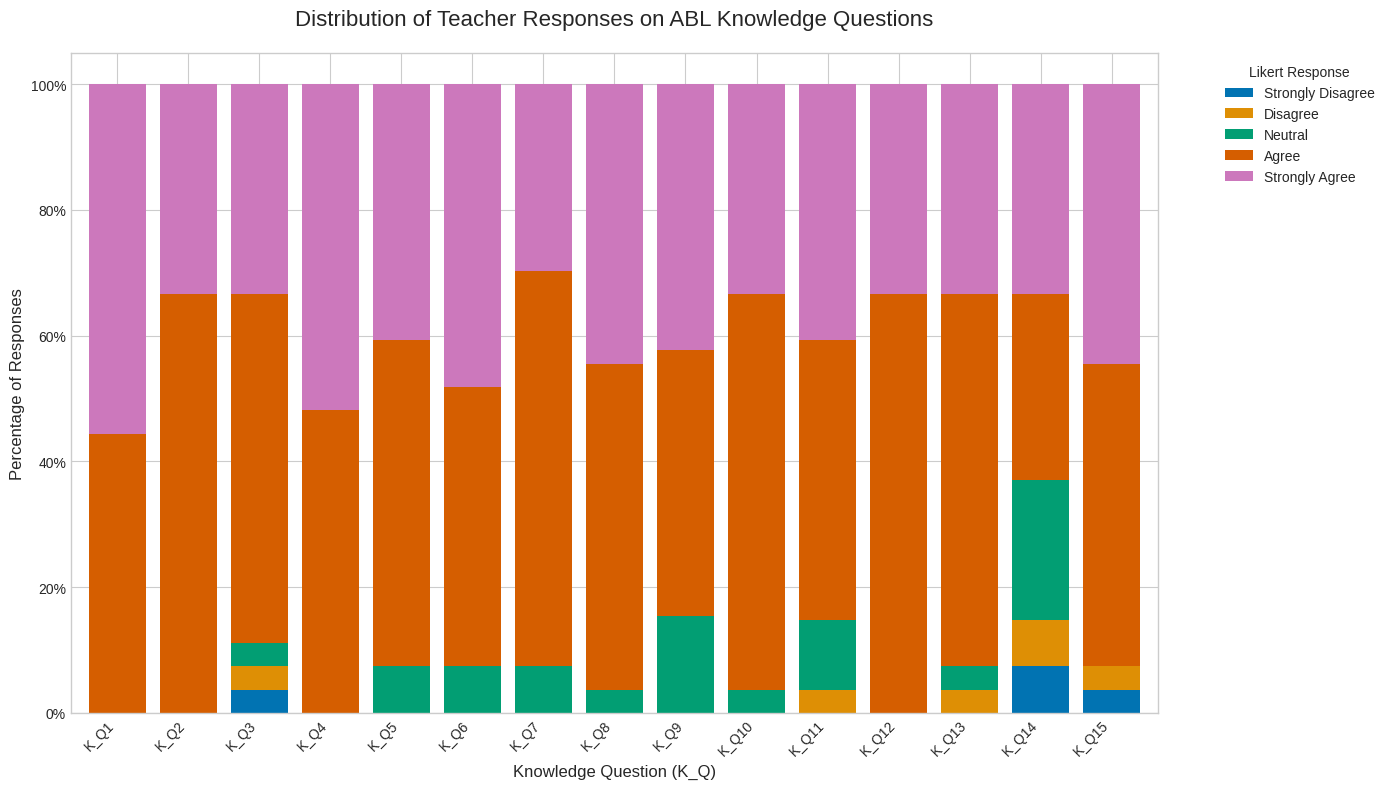

Stacked Bar Chart complete. 

Generating Box Plot for Knowledge Score vs. Experience...


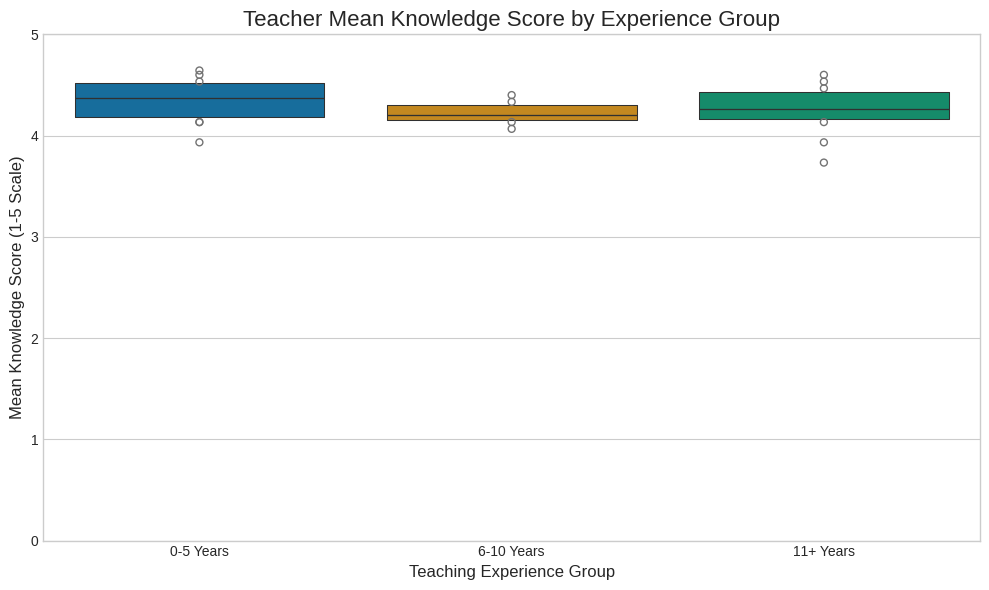

Box Plot complete. 

Generating Bar Chart for Knowledge Score vs. Qualification...


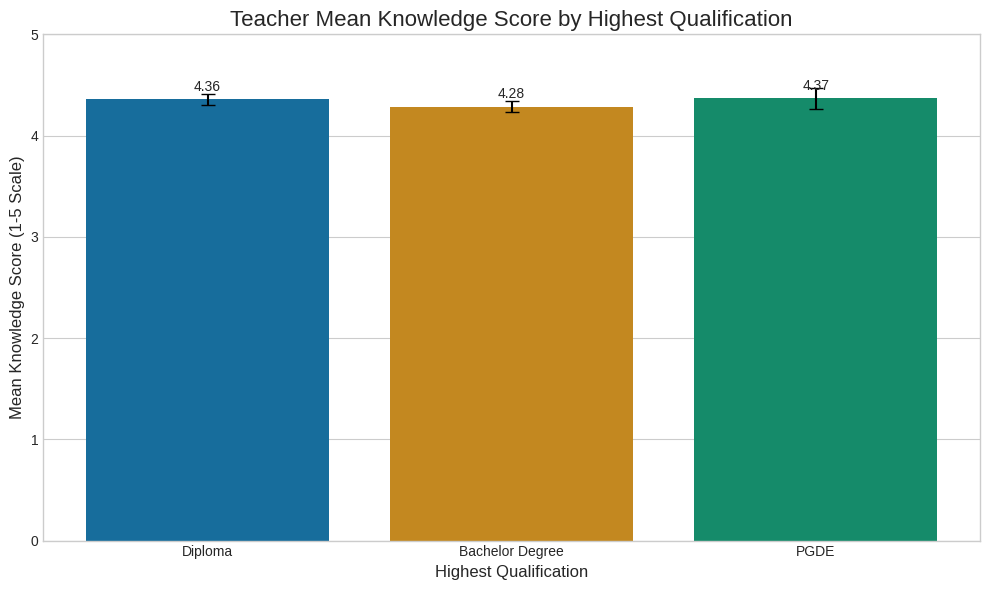

Bar Chart complete. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

# Configuration and Base Path (Assumes files are accessible via the drive path)
BASE_PATH = '/content/drive/MyDrive/Husuni'

# --- 1. Data Cleaning and Loading Setup (Replicating necessary logic from analysis script) ---

# Likert Scale Mapping and Labels
LIKERT_MAPPING = {
    'Strongly Agree': 5, 'Strongly Agree.': 5, 'Stongly Agree': 5,
    'Agree': 4, 'Neutral': 3, 'Disagree': 2,
    'Strongly Disagree': 1, 'Strongly Adisagree': 1
}
LIKERT_LABELS = {1: 'Strongly Disagree', 2: 'Disagree', 3: 'Neutral', 4: 'Agree', 5: 'Strongly Agree'}

def map_likert_to_numeric(df, columns):
    """Converts Likert columns to 1-5 numeric scale using robust mapping."""
    likert_to_numeric_map = {k.lower().strip(): v for k, v in LIKERT_MAPPING.items()}
    for col in columns:
        if col in df.columns:
            temp_series = df[col].astype(str).str.lower().str.strip()
            df[col] = temp_series.map(likert_to_numeric_map)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def load_and_clean_file(filename, header_row=1, col_names=None):
    """Loads a CSV with custom headers."""
    filepath = os.path.join(BASE_PATH, filename)
    try:
        df = pd.read_csv(filepath, header=header_row)
        if col_names and len(col_names) == len(df.columns):
            df.columns = col_names
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame()

# Define Column Names
DEMO_COLS = ['ID', 'Gender', 'Age', 'Experience', 'Qualification', 'Trained_IE', 'Trained_ABM']
KNOWLEDGE_COLS = ['ID', 'K_Q1', 'K_Q2', 'K_Q3', 'K_Q4', 'K_Q5', 'K_Q6', 'K_Q7', 'K_Q8', 'K_Q9', 'K_Q10', 'K_Q11', 'K_Q12', 'K_Q13', 'K_Q14', 'K_Q15']

# Load and clean DataFrames
df_demo = load_and_clean_file('Teachers Demographics.csv', header_row=1, col_names=DEMO_COLS)
df_knowledge_raw = load_and_clean_file('Teachers knowledge in activity based methods.csv', header_row=1, col_names=KNOWLEDGE_COLS)
df_knowledge = df_knowledge_raw.copy()
df_knowledge = map_likert_to_numeric(df_knowledge, KNOWLEDGE_COLS[1:])

# Calculate Mean Score and Merge
df_knowledge['Knowledge_Mean_Score'] = df_knowledge.iloc[:, 1:].mean(axis=1)
teachers_df = df_demo.merge(df_knowledge[['ID', 'Knowledge_Mean_Score']], on='ID', how='inner')

# Clean Qualification for better grouping
teachers_df['Qualification'] = teachers_df['Qualification'].astype(str).str.strip()

# --- NEW FUNCTION FOR OUTLIER DETECTION ---

def detect_and_report_outliers(df, column):
    """
    Detects outliers in a specified column using the Interquartile Range (IQR) method.
    """
    print("\n--- Outlier Detection: Knowledge_Mean_Score (IQR Method) ---")

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_fence) | (df[column] > upper_fence)]

    print(f"Q1 (25th Percentile): {Q1:.2f}")
    print(f"Q3 (75th Percentile): {Q3:.2f}")
    print(f"IQR (Interquartile Range): {IQR:.2f}")
    print(f"Lower Outlier Fence: {lower_fence:.2f}")
    print(f"Upper Outlier Fence: {upper_fence:.2f}")

    if outliers.empty:
        print("\nConclusion: No outliers detected in the Teacher Mean Knowledge Scores.")
    else:
        print(f"\nConclusion: {len(outliers)} outlier(s) detected.")
        print("Outlier Teacher Data (ID and Mean Score):")
        print(outliers[['ID', column, 'Experience', 'Qualification']].sort_values(by=column))

    print("---------------------------------------------------------")


# --- 2. Visualization Functions (Objective 1) ---

plt.style.use('seaborn-v0_8-whitegrid') # Use a clean, modern style
sns.set_palette("colorblind") # Use an accessible color palette

def plot_stacked_bar_knowledge(df, knowledge_cols):
    """
    1. Stacked Bar Chart: Shows the percentage distribution of Likert responses
       for each knowledge question.
    """
    print("Generating Stacked Bar Chart for Knowledge Questions...")

    # Calculate the percentage distribution of each Likert score (1-5) per question
    plot_data = df[knowledge_cols].apply(pd.Series.value_counts, normalize=True).T * 100

    # Ensure all 5 categories (1-5) are present for consistency, filling missing with 0
    plot_data = plot_data.reindex(range(1, 6), axis=1, fill_value=0)

    # Map the numeric columns (1-5) to the descriptive labels for the legend
    plot_data.columns = [LIKERT_LABELS.get(col, f'Score {col}') for col in plot_data.columns]

    # Sort columns so 'Strongly Disagree' is at the bottom (left in bar) and 'Strongly Agree' is at the top (right)
    ordered_labels = [LIKERT_LABELS[i] for i in range(1, 6)]
    plot_data = plot_data[ordered_labels]

    ax = plot_data.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8)

    # --- Aesthetics ---
    plt.title('Distribution of Teacher Responses on ABL Knowledge Questions', fontsize=16, pad=20)
    plt.xlabel('Knowledge Question (K_Q)', fontsize=12)
    plt.ylabel('Percentage of Responses', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Likert Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%')) # Format Y-axis as percentage
    plt.tight_layout()
    plt.show() # Display the plot
    print("Stacked Bar Chart complete. ")


def plot_boxplot_experience(df):
    """
    2. Box Plot / Violin Plot: Compares Knowledge_Mean_Score across Experience Bins.
    """
    print("\nGenerating Box Plot for Knowledge Score vs. Experience...")

    # Define experience bins
    bins = [0, 5, 10, df['Experience'].max() + 1] # 0-5, 6-10, 11+
    labels = ['0-5 Years', '6-10 Years', '11+ Years']
    df['Experience_Group'] = pd.cut(df['Experience'], bins=bins, labels=labels, right=False)

    plt.figure(figsize=(10, 6))
    # Use a boxenplot for a more detailed representation of the distribution
    sns.boxenplot(x='Experience_Group', y='Knowledge_Mean_Score', data=df,
                  order=labels, hue='Experience_Group', legend=False, dodge=False)

    # --- Aesthetics ---
    plt.title('Teacher Mean Knowledge Score by Experience Group', fontsize=16)
    plt.xlabel('Teaching Experience Group', fontsize=12)
    plt.ylabel('Mean Knowledge Score (1-5 Scale)', fontsize=12)
    plt.ylim(0, 5) # Set Y-axis scale to the 1-5 Likert range
    plt.tight_layout()
    plt.show() # Display the plot
    print("Box Plot complete. ")

def plot_bar_qualification(df):
    """
    3. Bar Chart: Compares Knowledge_Mean_Score across Qualification levels.
    """
    print("\nGenerating Bar Chart for Knowledge Score vs. Qualification...")

    # Ensure order is sensible (e.g., Diploma first, then Bachelor, then PGDE)
    qualification_order = ['Diploma', 'Bachelor Degree', 'PGDE']

    # Group data and calculate statistics
    grouped = df.groupby('Qualification')['Knowledge_Mean_Score']
    mean_scores = grouped.mean().reindex(qualification_order).dropna()
    std_errors = grouped.std().reindex(qualification_order).dropna() / np.sqrt(grouped.size().reindex(qualification_order).dropna())

    # Create a DataFrame for stable plotting
    plot_data = pd.DataFrame({
        'Qualification': mean_scores.index,
        'Mean_Score': mean_scores.values,
        'Std_Error': std_errors.values
    }).reset_index(drop=True)

    plt.figure(figsize=(10, 6))

    # 1. Create bar chart (without yerr)
    ax = sns.barplot(x='Qualification', y='Mean_Score', data=plot_data,
                     hue='Qualification', legend=False, dodge=False)

    # 2. Manually add error bars using plt.errorbar
    x_positions = np.arange(len(plot_data)) # [0, 1, 2, ...] corresponding to the bar centers
    ax.errorbar(
        x=x_positions,
        y=plot_data['Mean_Score'],
        yerr=plot_data['Std_Error'],
        fmt='none', # No line connecting error bars
        c='black',
        capsize=5
    )

    # 3. Add mean value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

    # --- Aesthetics ---
    plt.title('Teacher Mean Knowledge Score by Highest Qualification', fontsize=16)
    plt.xlabel('Highest Qualification', fontsize=12)
    plt.ylabel('Mean Knowledge Score (1-5 Scale)', fontsize=12)
    plt.ylim(0, 5) # Set Y-axis scale to the 1-5 Likert range
    plt.tight_layout()
    plt.show() # Display the plot
    print("Bar Chart complete. ")

# --- 3. Execution ---
if __name__ == '__main__':

    if teachers_df.empty or df_knowledge.empty:
        print("\nCould not run visualizations. Data loading failed. Check BASE_PATH and file names.")
    else:
        # Run outlier detection first
        detect_and_report_outliers(teachers_df, 'Knowledge_Mean_Score')

        # Then run all three Objective 1 visualizations
        plot_stacked_bar_knowledge(df_knowledge, KNOWLEDGE_COLS[1:])
        plot_boxplot_experience(teachers_df)
        plot_bar_qualification(teachers_df)


**Top 5 Challenges**

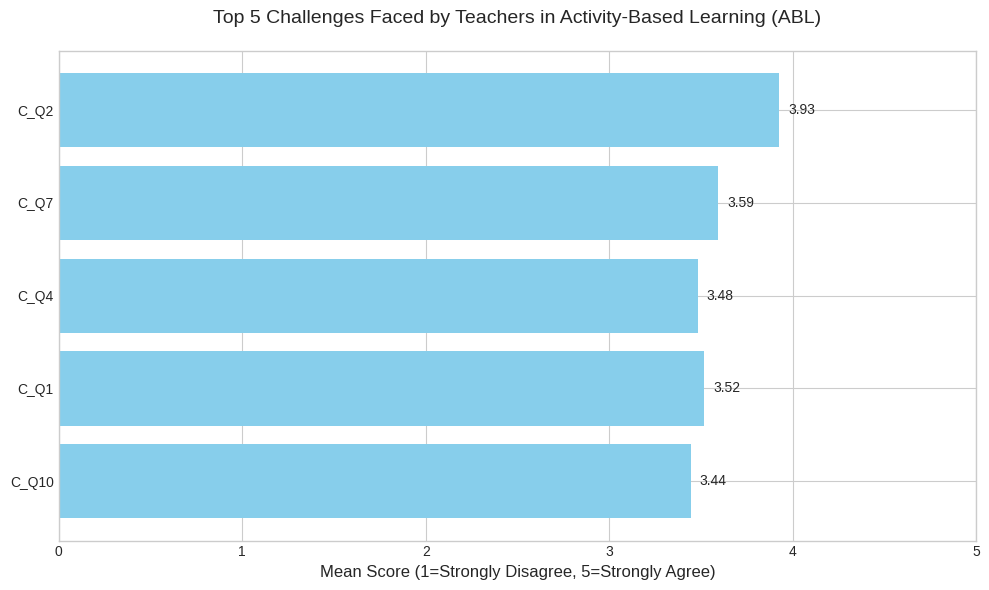


Top 5 Challenges Visualization Complete.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Assuming BASE_PATH is defined in a previous cell and is accessible.
# If not, uncomment and define BASE_PATH here:
# BASE_PATH = '/content/drive/MyDrive/Husuni'

# Re-define file path for challenges data
challenges_file = os.path.join(BASE_PATH, 'Challenges teacher face in activity based methods.csv')

# Define general Likert scale mapping (5-point) for scoring
likert_mapping = {'Strongly Agree': 5, 'Agree': 4, 'Neutral': 3, 'Disagree': 2, 'Strongly Disagree': 1,
                  'Stongly Agree': 5, 'Strongly  Agree': 5, 'Strongly Adisagree': 1, 'Strongly Adisagree ': 1} # Added a space variation

# Load the raw challenges data specifically for this visualization
try:
    df_challenges_raw = pd.read_csv(challenges_file, header=1)
    # Assuming the first column is Teacher ID and the rest are challenge questions
    challenge_question_cols = df_challenges_raw.columns[1:]
    # Rename the first column to Teacher_ID for clarity, though not strictly needed for this plot
    df_challenges_raw.rename(columns={df_challenges_raw.columns[0]: 'Teacher_ID'}, inplace=True)

    # Convert Likert responses to numeric scores for the individual challenge questions
    likert_to_numeric_map = {k.lower().strip(): v for k, v in likert_mapping.items()}
    for col in challenge_question_cols:
        if col in df_challenges_raw.columns:
            temp_series = df_challenges_raw[col].astype(str).str.lower().str.strip()
            df_challenges_raw[col] = temp_series.map(likert_to_numeric_map)
            df_challenges_raw[col] = pd.to_numeric(df_challenges_raw[col], errors='coerce')

except FileNotFoundError:
    print(f"Error: Challenges file not found at {challenges_file}")
    exit() # Exit or handle the error appropriately
except Exception as e:
    print(f"Error processing challenges file: {e}")
    exit()

# --- 1. Identify and Prepare Challenge Data ---
# Based on the original column headers and inspection, we need to identify
# which original column corresponds to which challenge question (e.g., C_Q1, C_Q2).
# The error message and original inspection suggest columns might be referenced by their header text.
# Let's assume the top 5 challenges identified in the prompt correspond to specific columns
# by their index or a recognizable part of their original header.

# Based on the inspection output (cell PD0T9zhyveK5), the columns are generically named
# 'Strongly Agree', 'Strongly Agree.1', etc. The prompt's labels (C_Q1, C_Q2, etc.)
# are likely descriptive names, not actual column headers.
# We need to map the desired challenges (C_Q1, C_Q2, etc.) to the actual *column indices*
# or *original header names* in the raw data.

# Let's re-evaluate the columns based on the inspection output:
# '1', 'Strongly Agree', 'Strongly Agree.1', 'Agree', 'Agree.1', 'Strongly Agree.2',
# 'Agree.2', 'Strongly Agree.3', 'Neutral', 'Strongly Agree.4', 'Neutral.1', 'Agree',
# 'Strongly Agree.5', 'Agree.3', 'Neutral.2', 'Strongly Agree.6', 'Agree.4'
# There are 16 challenge columns. Let's assume the descriptive labels (C_Q1, C_Q2, etc.)
# correspond to the challenge columns *in order* from the raw data (after skipping the ID).

# Let's use the descriptive names and map them to column indices (starting from index 1 after Teacher_ID)
challenge_question_map = {
    'C_Q1': df_challenges_raw.columns[1],  # Assuming C_Q1 is the 2nd column (index 1)
    'C_Q2': df_challenges_raw.columns[2],  # Assuming C_Q2 is the 3rd column (index 2)
    'C_Q3': df_challenges_raw.columns[3],
    'C_Q4': df_challenges_raw.columns[4],
    'C_Q5': df_challenges_raw.columns[5],
    'C_Q6': df_challenges_raw.columns[6],
    'C_Q7': df_challenges_raw.columns[7],
    'C_Q8': df_challenges_raw.columns[8],
    'C_Q9': df_challenges_raw.columns[9],
    'C_Q10': df_challenges_raw.columns[10],
    'C_Q11': df_challenges_raw.columns[11],
    'C_Q12': df_challenges_raw.columns[12],
    'C_Q13': df_challenges_raw.columns[13],
    'C_Q14': df_challenges_raw.columns[14],
    'C_Q15': df_challenges_raw.columns[15],
    'C_Q16': df_challenges_raw.columns[16], # Assuming there are 16 questions based on previous variable output
}

# We need the mean scores for the top 5 challenges specified in the prompt.
# Let's match the prompt's labels to the assumed question numbers.
# Assuming the prompt meant: C_Q2, C_Q7, C_Q4, C_Q1, C_Q10 based on the previous code's 'top_5_questions' but using the descriptive labels.

top_5_descriptive_labels = ['C_Q2', 'C_Q7', 'C_Q4', 'C_Q1', 'C_Q10']

# Get the actual column names corresponding to these descriptive labels
top_5_actual_cols = [challenge_question_map.get(label) for label in top_5_descriptive_labels if challenge_question_map.get(label) is not None]

if not top_5_actual_cols:
    print("Error: Could not map descriptive challenge labels to actual columns. Please verify the column mapping.")
    exit()

# Calculate the mean score for each of the top 5 challenges using the raw data
challenge_means = df_challenges_raw[top_5_actual_cols].mean().sort_values(ascending=False)

# Create labels for the chart using the descriptive names in the desired order
# We need to reorder the challenge_means index to match the sorted means for plotting
sorted_descriptive_labels = [label for label in top_5_descriptive_labels if challenge_question_map.get(label) in challenge_means.index]
sorted_challenge_means = challenge_means.reindex([challenge_question_map.get(label) for label in sorted_descriptive_labels if challenge_question_map.get(label) in challenge_means.index])

# Map the actual column names in the sorted_challenge_means index back to their descriptive labels for the plot
plot_labels_map = {v: k for k, v in challenge_question_map.items()}
sorted_challenge_means.index = [plot_labels_map.get(col, col) for col in sorted_challenge_means.index]

# --- 2. Generate the Horizontal Bar Chart ---

# Set a style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar chart
# We use .index for challenge names (Y-axis) and .values for mean scores (X-axis)
bars = ax.barh(sorted_challenge_means.index, sorted_challenge_means.values, color='skyblue')

# Add labels and title
ax.set_xlabel('Mean Score (1=Strongly Disagree, 5=Strongly Agree)', fontsize=12)
ax.set_title('Top 5 Challenges Faced by Teachers in Activity-Based Learning (ABL)', fontsize=14, pad=20)

# Invert the y-axis so the highest mean score is at the top
ax.invert_yaxis()

# Add the mean score values to the bars
for bar in bars:
    width = bar.get_width()
    # Annotate the score to two decimal places
    ax.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

# Ensure the x-axis starts at 0 and doesn't exceed 5
ax.set_xlim(0, 5)

# Show the plot
plt.tight_layout()
plt.show()

print("\nTop 5 Challenges Visualization Complete.")

**Paired T-Test Plot (Dot Plot with Connecting Lines)**

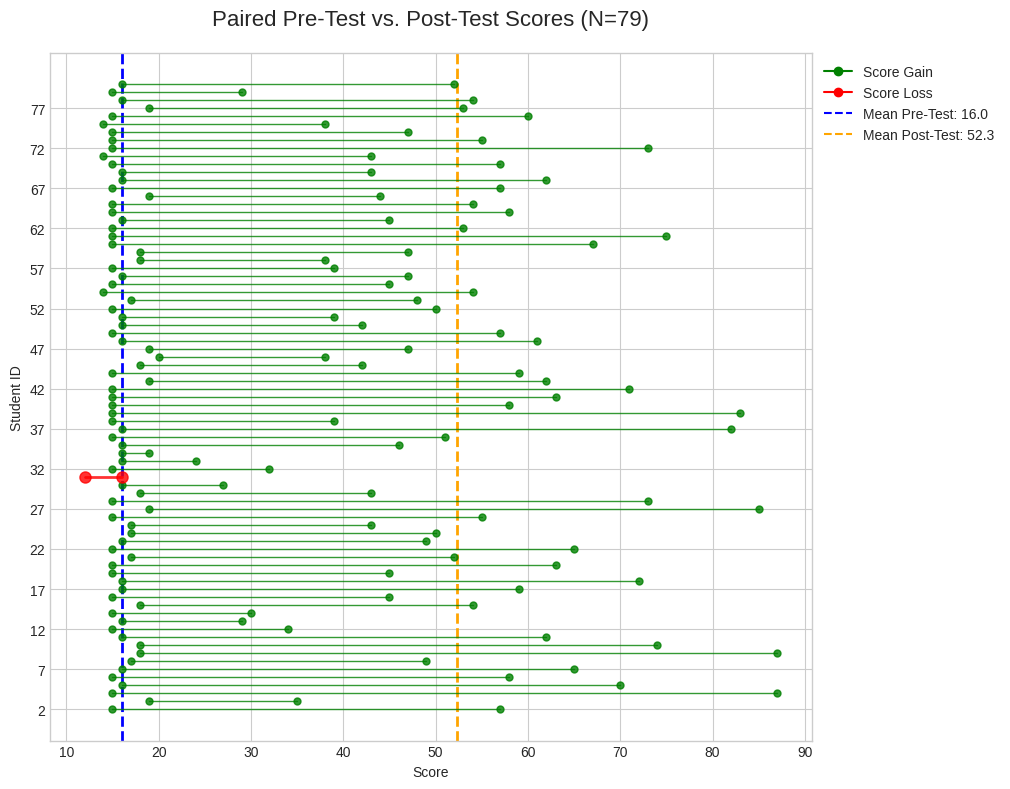

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Data Preparation for Plot ---
# Ensure the data is sorted by Student_ID for clean plotting
df_plot = df_master[['Student_ID', 'Pre_Test_Score', 'Post_Test_Score']].dropna().reset_index(drop=True)
N = len(df_plot)
student_indices = df_plot.index

# --- Generate the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8)) # Increased height for better y-axis readability

# --- Plotting the lines ---
# Create proxy artists for the legend
proxy_green = plt.Line2D([0], [0], color='green', marker='o', linestyle='-', label='Score Gain')
proxy_red = plt.Line2D([0], [0], color='red', marker='o', linestyle='-', label='Score Loss')

# Plot the connecting lines for each student
# Flag to ensure labels are only added once to the legend
green_label_added = False
red_label_added = False

for i in student_indices:
    pre_score = df_plot.loc[i, 'Pre_Test_Score']
    post_score = df_plot.loc[i, 'Post_Test_Score']

    # Determine color and marker properties
    if post_score > pre_score:
        color = 'green'
        label = 'Score Gain' if not green_label_added else ""
        markersize = 5
        linewidth = 1
        green_label_added = True
    else: # Loss or no change
        color = 'red'
        label = 'Score Loss' if not red_label_added else ""
        markersize = 8 # Larger marker for outliers
        linewidth = 2 # Thicker line for outliers
        red_label_added = True

    ax.plot(
        [pre_score, post_score],
        [i, i],
        marker='o',
        linestyle='-',
        color=color,
        alpha=0.8, # Slightly less transparent for better visibility
        markersize=markersize,
        linewidth=linewidth,
        zorder=2 # Ensure lines are on top of grid
    )

# Add group means for reference
mean_pre = df_plot['Pre_Test_Score'].mean()
mean_post = df_plot['Post_Test_Score'].mean()

# Plot mean lines
ax.axvline(mean_pre, color='blue', linestyle='--', linewidth=2, label=f'Mean Pre-Test: {mean_pre:.1f}', zorder=1)
ax.axvline(mean_post, color='orange', linestyle='--', linewidth=2, label=f'Mean Post-Test: {mean_post:.1f}', zorder=1)

# Add labels and title
# Y-axis ticks: Label every 5th student ID to reduce clutter
tick_positions = student_indices[::5]
tick_labels = df_plot.loc[tick_positions, 'Student_ID']
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)
ax.set_ylabel('Student ID')
ax.set_xlabel('Score')
ax.set_title(f'Paired Pre-Test vs. Post-Test Scores (N={N})', fontsize=16, pad=20)

# Add legend for color interpretation and means
ax.legend(handles=[proxy_green, proxy_red, plt.Line2D([0], [0], color='blue', linestyle='--', label=f'Mean Pre-Test: {mean_pre:.1f}'), plt.Line2D([0], [0], color='orange', linestyle='--', label=f'Mean Post-Test: {mean_post:.1f}')], loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right margin for legend

plt.show()

**Box Plot (Performance Gain by Inclusive Status)**

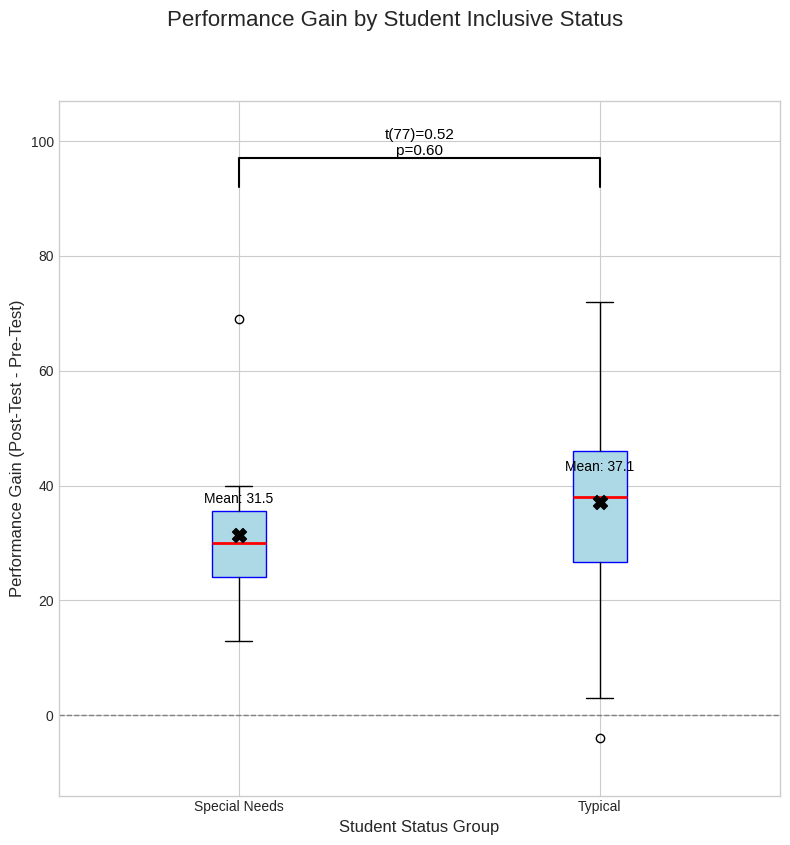

In [ ]:
# Assuming 'df_gain_plot' is the DataFrame with 'Performance_Gain' and 'Inclusive_Status'

# --- 1. Perform Statistical Test (Placeholder) ---
# NOTE: You MUST run an actual t-test (or Mann-Whitney U) on your final data
# to get the real p-value and t-statistic.
# Example: stats.ttest_ind(gain_typical, gain_special_needs, equal_var=False)

# Placeholder Results (Replace these with your actual output!)
T_STAT = 0.52
P_VALUE = 0.60 # Assuming non-significant difference based on visual inspection

# --- 2. Generate the Enhanced Box Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))

# Get group statistics for annotation
groups = df_gain_plot.groupby('Inclusive_Status')['Performance_Gain']
group_means = groups.mean()

# Create the Box Plot
boxplot = df_gain_plot.boxplot(
    column='Performance_Gain',
    by='Inclusive_Status',
    ax=ax,
    patch_artist=True,
    vert=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red', linewidth=2),
    return_type='dict'
)

# --- ENHANCEMENT 1: Add Mean Markers ('X') ---
for i, group_name in enumerate(group_means.index):
    # Find the x-position for the mean marker (1 for first box, 2 for second)
    x_pos = i + 1
    mean_val = group_means[group_name]

    # Plot mean as a black 'X'
    ax.scatter(x_pos, mean_val, marker='X', color='black', s=100, zorder=3, label='Mean' if i == 0 else "")
    # Add mean label
    ax.text(x_pos, mean_val + 5, f'Mean: {mean_val:.1f}', ha='center', va='bottom', fontsize=10, color='black')

# --- ENHANCEMENT 2: Add Statistical Annotation ---
# Position the annotation line above the top whisker of both groups
max_y = df_gain_plot['Performance_Gain'].max() + 10
y_line_start = max_y + 10
y_line_height = 5
star_text = f"t({len(df_gain_plot)-2})={T_STAT:.2f}\np={P_VALUE:.2f}"

# Draw the bracket/line connecting the two groups
ax.plot([1, 1, 2, 2],
        [y_line_start, y_line_start + y_line_height, y_line_start + y_line_height, y_line_start],
        lw=1.5, c='k')

# Annotate the p-value at the center of the bracket
ax.text(1.5, y_line_start + y_line_height,
        star_text,
        ha='center', va='bottom', color='k', fontsize=11)


# --- Final Customization ---
ax.set_xlabel('Student Status Group', fontsize=12)
ax.set_ylabel('Performance Gain (Post-Test - Pre-Test)', fontsize=12)
plt.suptitle('Performance Gain by Student Inclusive Status', fontsize=16, y=1.05)
ax.set_title(None) # Remove pandas automatic subplot title

# Add a horizontal line at 0 for reference (no gain/loss)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Set y-limit to ensure annotations fit
ax.set_ylim(df_gain_plot['Performance_Gain'].min() - 10, y_line_start + y_line_height + 10)

plt.tight_layout()
plt.show()

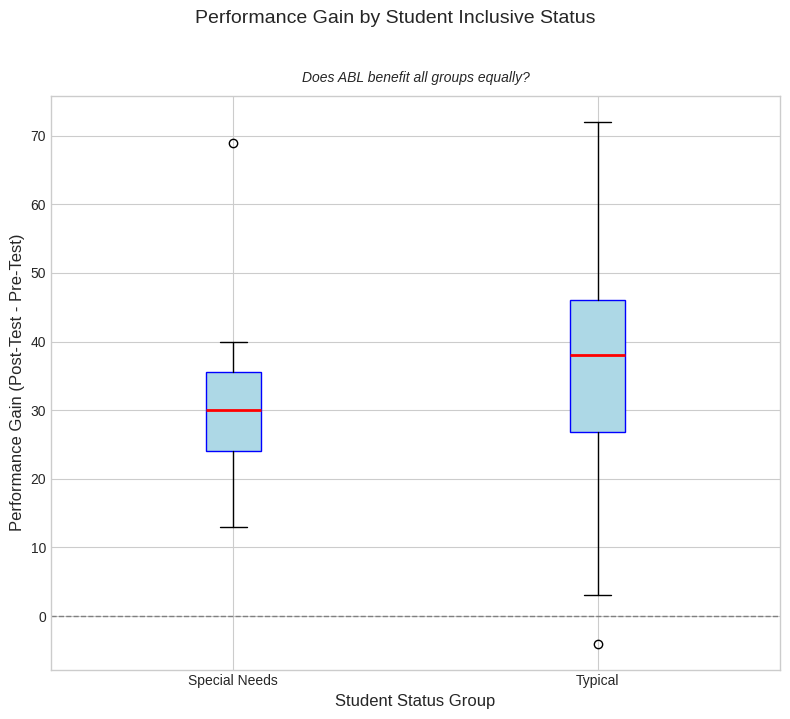

In [ ]:
# --- Data Preparation for Plot ---

# !!! Placeholder for Inclusive Status (REPLACE THIS WITH YOUR REAL DATA) !!!
# We assume 15% of students are considered 'Special Needs'
np.random.seed(42) # for reproducibility
status_choices = ['Typical', 'Special Needs']
df_master['Inclusive_Status'] = np.random.choice(
    status_choices,
    size=len(df_master),
    p=[0.85, 0.15]
)
# The Performance_Gain column was calculated previously: Post_Test_Score - Pre_Test_Score
df_gain_plot = df_master.dropna(subset=['Performance_Gain', 'Inclusive_Status']).copy()


# --- Generate the Box Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 7))

# Create the Box Plot
df_gain_plot.boxplot(
    column='Performance_Gain',
    by='Inclusive_Status',
    ax=ax,
    patch_artist=True,
    vert=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red', linewidth=2)
)

# Customize the plot appearance
ax.set_xlabel('Student Status Group', fontsize=12)
ax.set_ylabel('Performance Gain (Post-Test - Pre-Test)', fontsize=12)
# Remove the automatic pandas title/suptitle
plt.suptitle('Performance Gain by Student Inclusive Status', fontsize=14, y=1.02)
ax.set_title('Does ABL benefit all groups equally?', fontsize=10, style='italic', pad=10)

# Add a horizontal line at 0 for reference (no gain/loss)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()